In [1]:
import pandas as pd

df = pd.read_csv("ames.csv")

features = [
    "Gr.Liv.Area", "Garage.Area", "Total.Bsmt.SF", "Year.Built", "Year.Remod.Add",
    "Full.Bath", "Fireplaces", "TotRms.AbvGrd", "Lot.Area", "Garage.Cars",
    "MS.Zoning", "Neighborhood", "House.Style", "Exter.Qual", "Kitchen.Qual",
    "SalePrice"
]
df_new = df[features]
df_new

,Gr.Liv.Area,Garage.Area,Total.Bsmt.SF,Year.Built,Year.Remod.Add,Full.Bath,Fireplaces,TotRms.AbvGrd,Lot.Area,Garage.Cars,MS.Zoning,Neighborhood,House.Style,Exter.Qual,Kitchen.Qual,SalePrice
0,1656,528.0,1080.0,1960,1960,1,2,7,31770,2.0,RL,NAmes,1Story,TA,TA,215000
1,896,730.0,882.0,1961,1961,1,0,5,11622,1.0,RH,NAmes,1Story,TA,TA,105000
2,1329,312.0,1329.0,1958,1958,1,0,6,14267,1.0,RL,NAmes,1Story,TA,Gd,172000
3,2110,522.0,2110.0,1968,1968,2,2,8,11160,2.0,RL,NAmes,1Story,Gd,Ex,244000
4,1629,482.0,928.0,1997,1998,2,1,6,13830,2.0,RL,Gilbert,2Story,TA,TA,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,1003,588.0,1003.0,1984,1984,1,0,6,7937,2.0,RL,Mitchel,SLvl,TA,TA,142500
2926,902,484.0,864.0,1983,1983,1,0,5,8885,2.0,RL,Mitchel,1Story,TA,TA,131000
2927,970,0.0,912.0,1992,1992,1,0,6,10441,0.0,RL,Mitchel,SFoyer,TA,TA,132000
2928,1389,418.0,1389.0,1974,1975,1,1,6,10010,2.0,RL,Mitchel,1Story,TA,TA,170000


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings

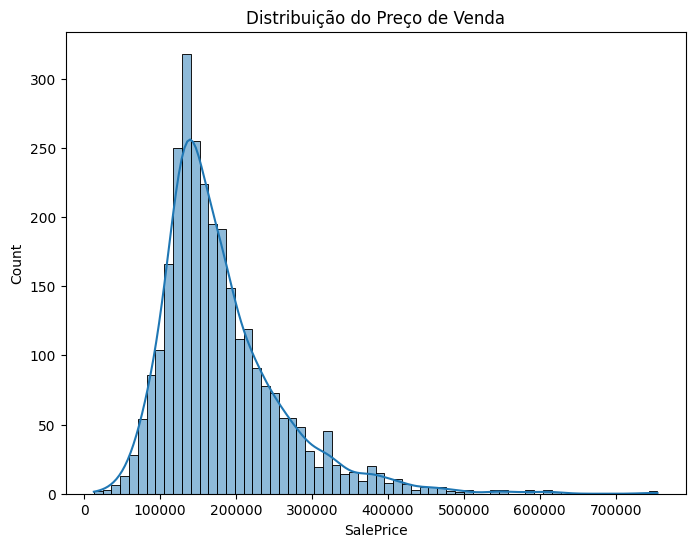

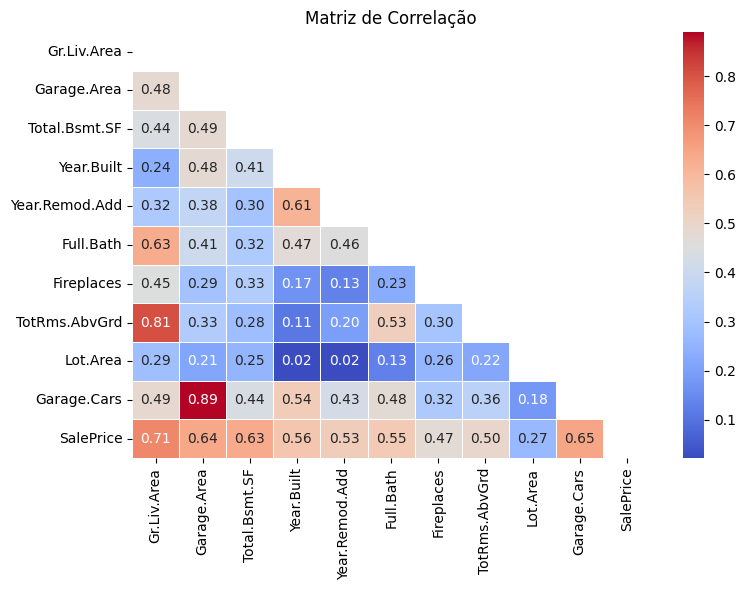

In [3]:
# Distribuição do preço de venda
plt.figure(figsize=(8, 6))
sns.histplot(df_new['SalePrice'], kde=True)
plt.title('Distribuição do Preço de Venda')
plt.show()

# Matriz de correlação para variáveis numéricas
numeric_columns = df_new.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = df_new[numeric_columns].corr()
plt.figure(figsize=(8, 6))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', linewidth=0.5)
plt.title('Matriz de Correlação')
plt.tight_layout()
plt.show()

Top 5 correlações com o preço de venda:
SalePrice        1.000000
Gr.Liv.Area      0.706780
Garage.Cars      0.647877
Garage.Area      0.640401
Total.Bsmt.SF    0.632280
Year.Built       0.558426
Name: SalePrice, dtype: float64


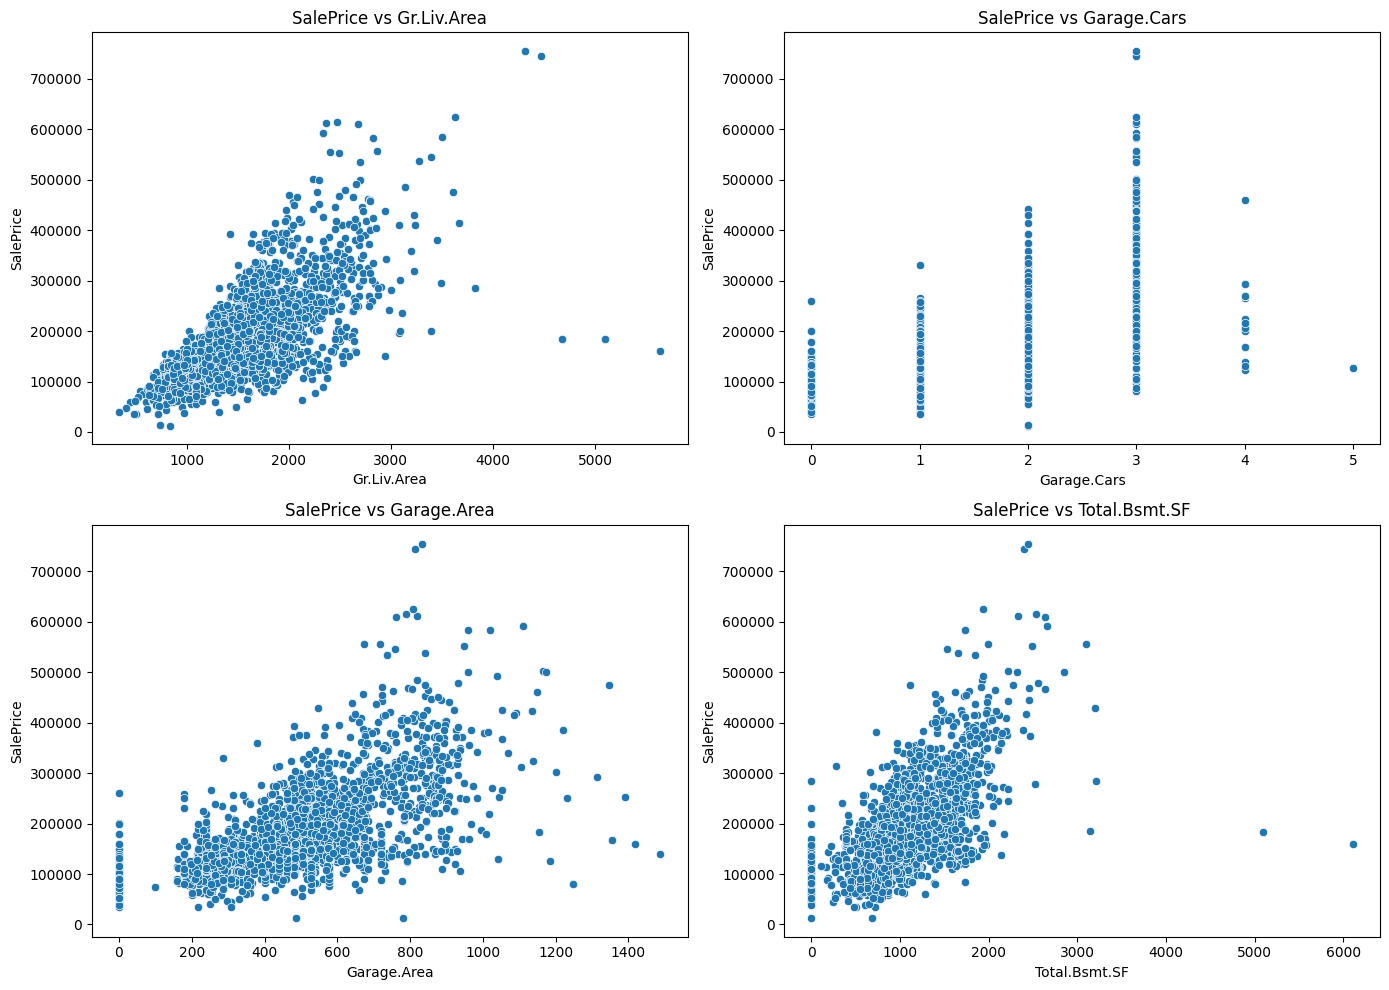

In [4]:
# Top 5 correlações com o preço de venda
price_corr = corr_matrix['SalePrice'].sort_values(ascending=False)
print("Top 5 correlações com o preço de venda:")
print(price_corr.head(6))

# Gráficos de dispersão para os principais recursos numéricos
top_num_features = price_corr.index[1:6]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feature in enumerate(top_num_features[:4]):
    sns.scatterplot(x=feature, y='SalePrice', data=df_new, ax=axes[i])
    axes[i].set_title(f'SalePrice vs {feature}')

plt.tight_layout()
plt.show()

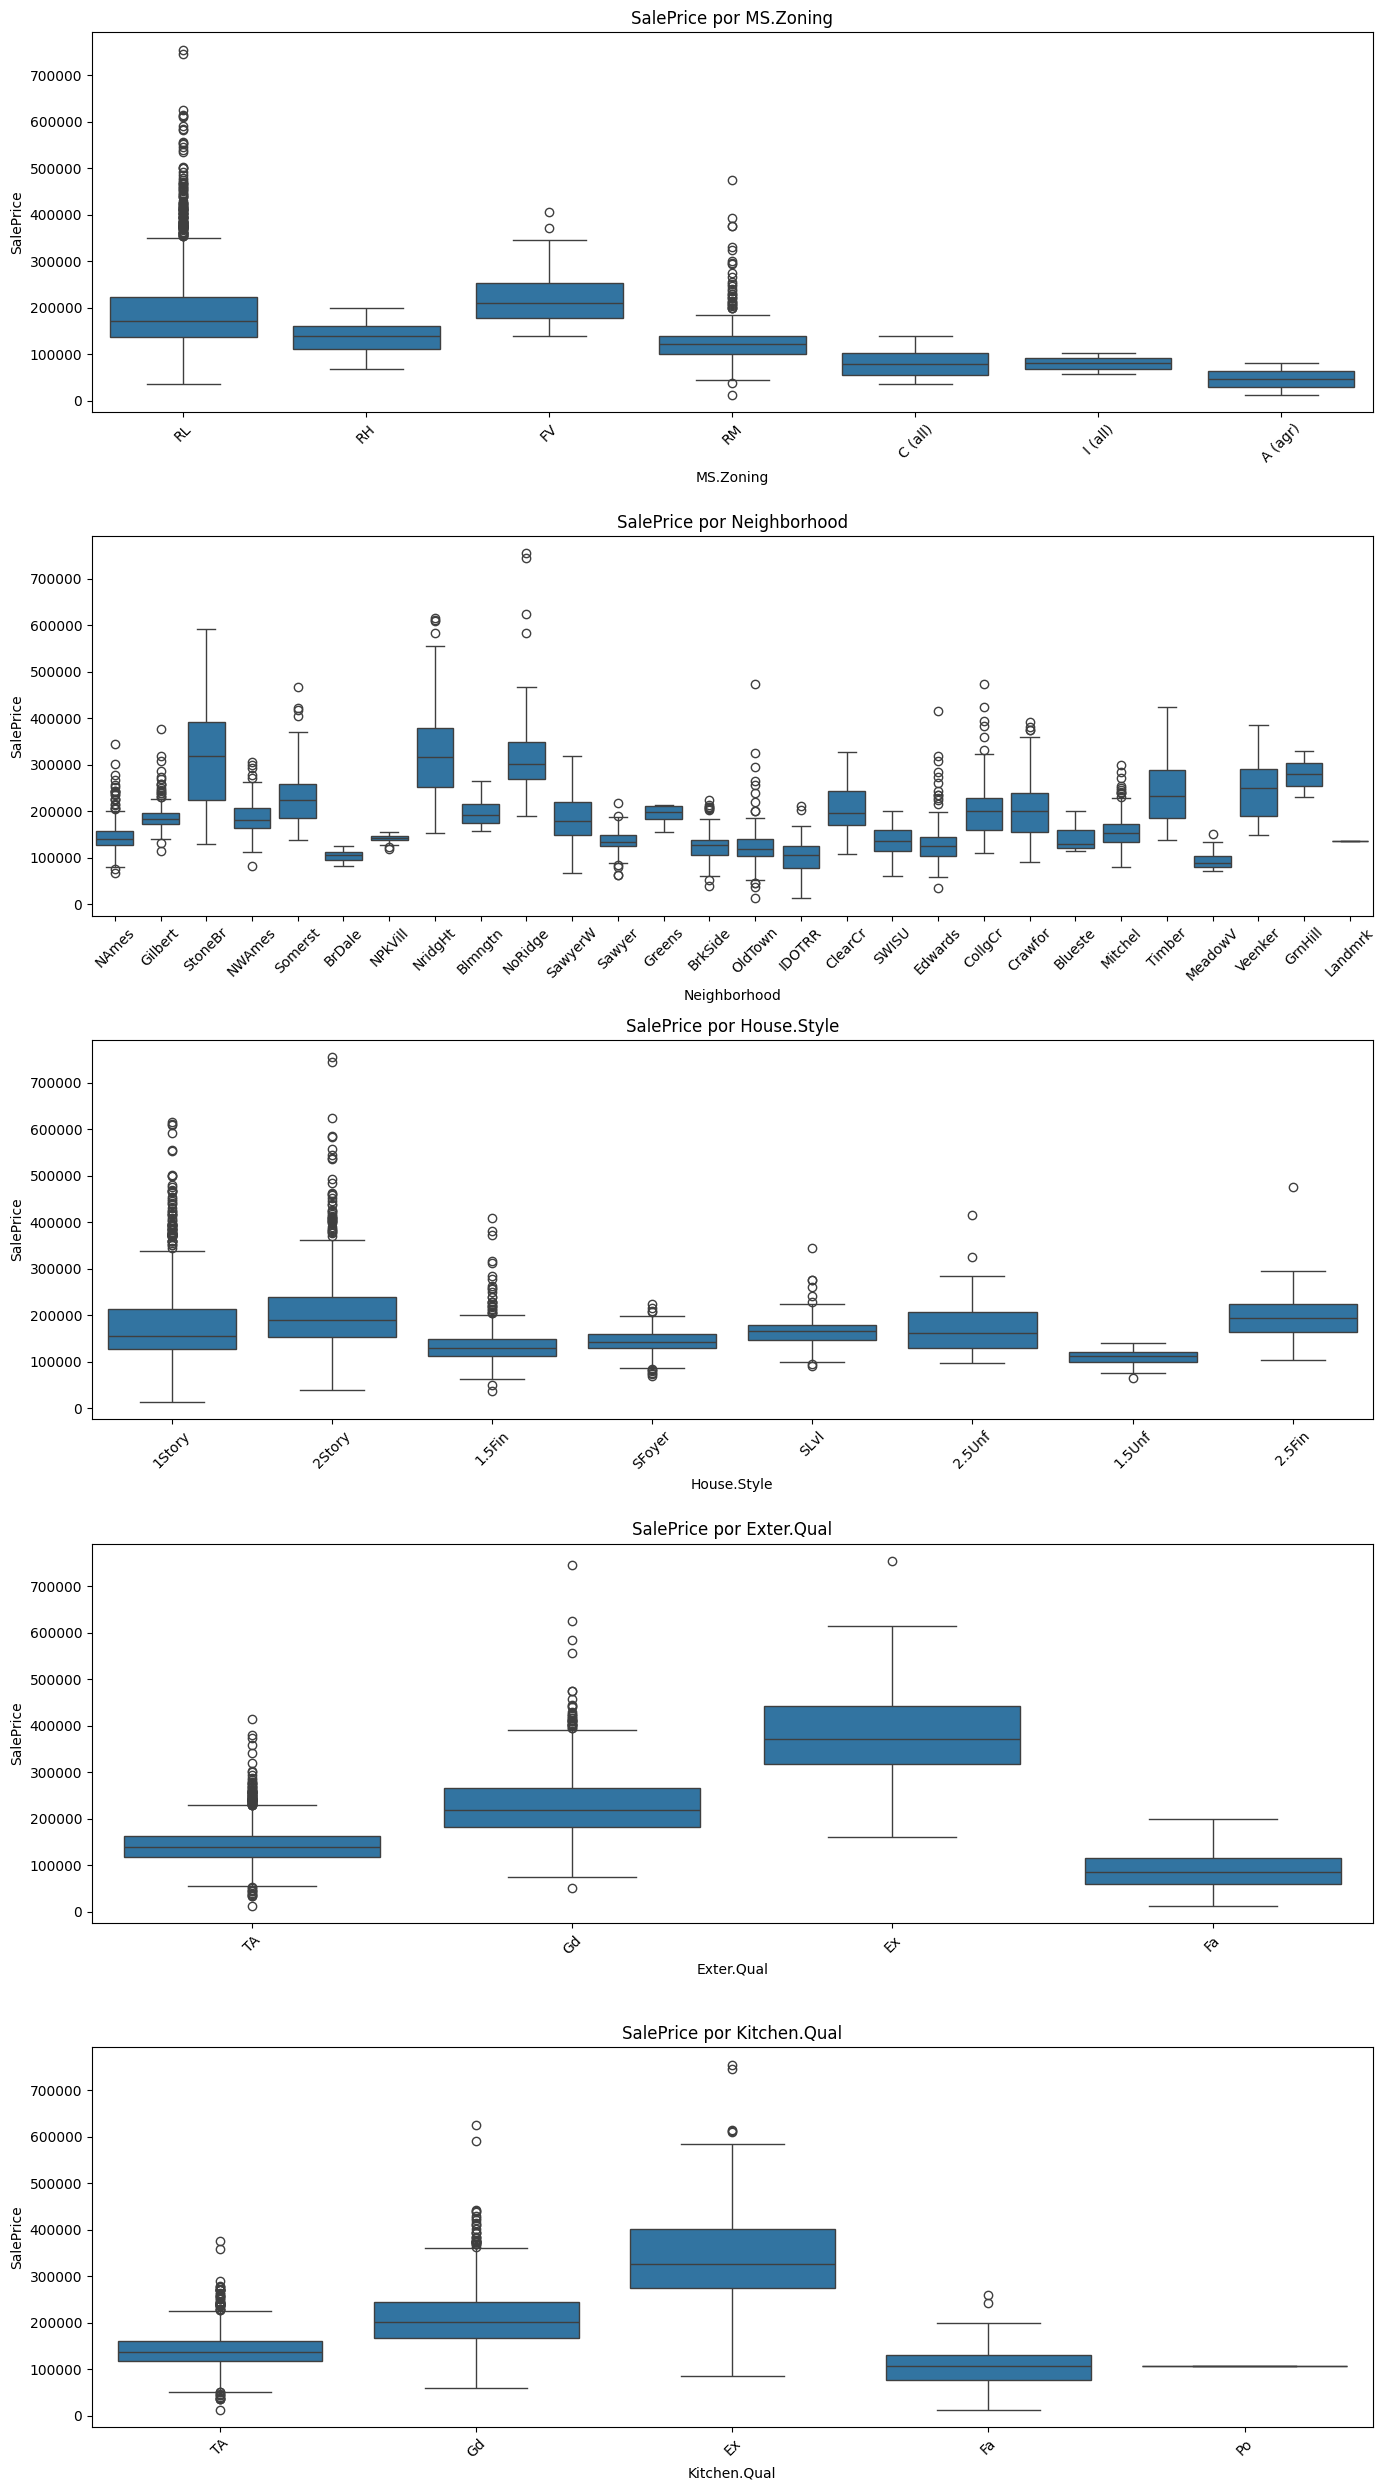

In [5]:
# Célula 4: Análise de Variáveis Categóricas
cat_features = df_new.select_dtypes(include=['object']).columns
fig, axes = plt.subplots(len(cat_features), 1, figsize=(14, 5*len(cat_features)))

for i, feature in enumerate(cat_features):
    sns.boxplot(x=feature, y='SalePrice', data=df_new, ax=axes[i])
    axes[i].set_title(f'SalePrice por {feature}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [6]:
# Célula 5: Verificação de Dados Faltantes
missing_data = df_new.isnull().sum()
missing_percent = (missing_data / len(df_new)) * 100
missing_df = pd.DataFrame({'Missing Count': missing_data, 'Percent': missing_percent})
print("Dados faltantes:")
print(missing_df[missing_df['Missing Count'] > 0])

Dados faltantes:
               Missing Count  Percent
Garage.Area                1  0.03413
Total.Bsmt.SF              1  0.03413
Garage.Cars                1  0.03413


Outliers em Gr.Liv.Area: 75 (2.56%)
Outliers em Garage.Area: 42 (1.43%)
Outliers em Total.Bsmt.SF: 123 (4.20%)
Outliers em Year.Built: 9 (0.31%)
Outliers em Full.Bath: 4 (0.14%)
Outliers em Fireplaces: 13 (0.44%)
Outliers em TotRms.AbvGrd: 51 (1.74%)
Outliers em Lot.Area: 127 (4.33%)
Outliers em Garage.Cars: 17 (0.58%)


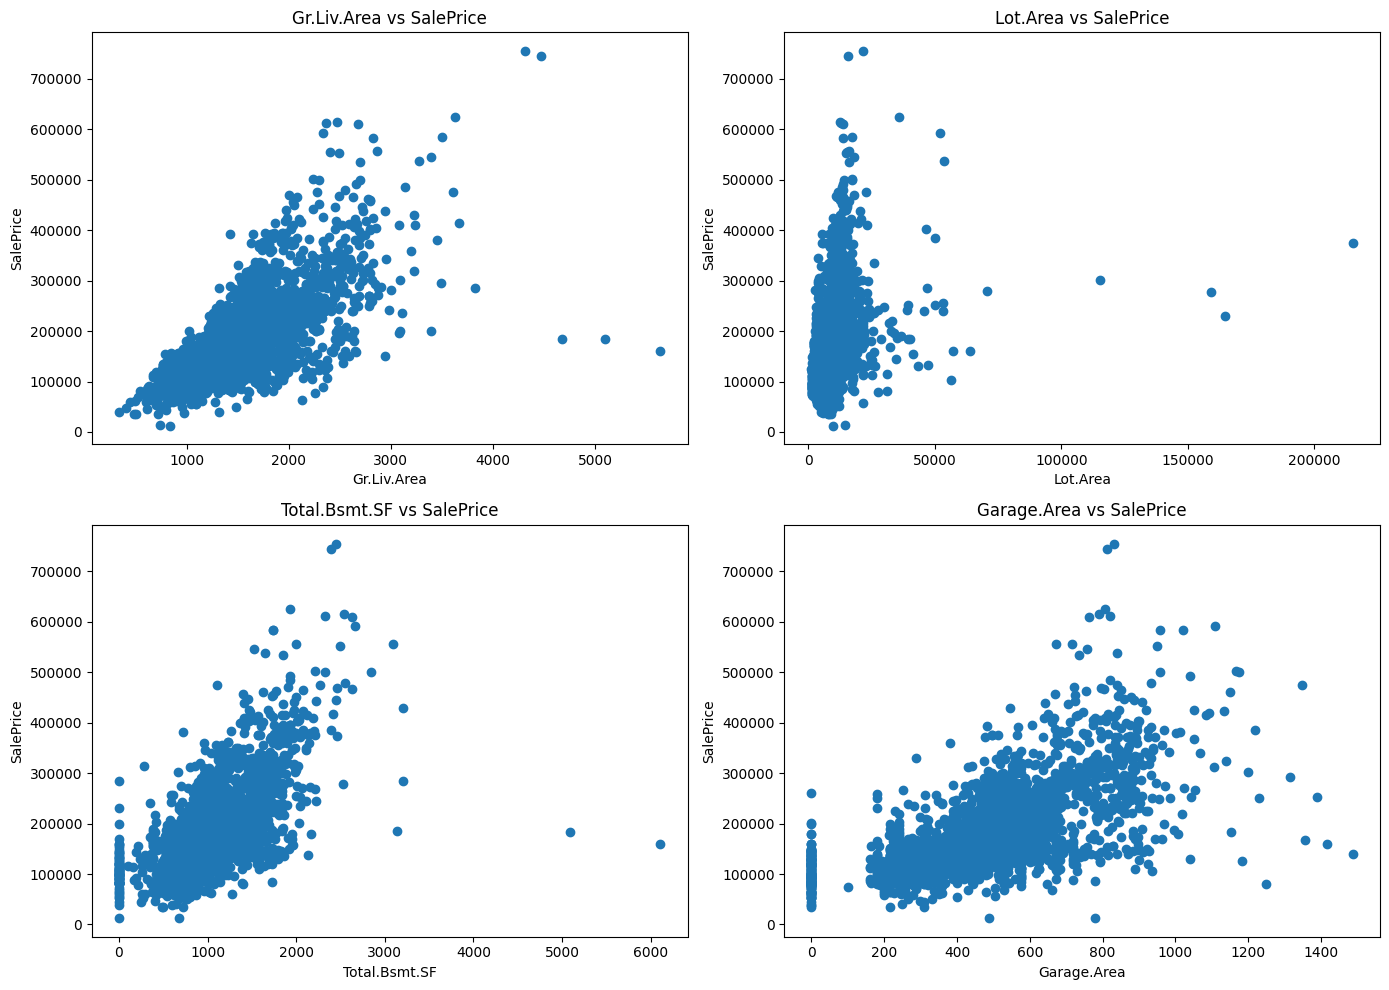

In [7]:
# Célula 6: Identificação de Outliers
def detect_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] < lower_bound) | (df[col] > upper_bound)]

# Identificando outliers nas principais variáveis numéricas
for col in numeric_columns:
    if col != 'SalePrice':
        outliers = detect_outliers(df_new, col)
        if not outliers.empty:
            print(f"Outliers em {col}: {len(outliers)} ({(len(outliers)/len(df_new))*100:.2f}%)")

# Visualizando outliers em algumas variáveis importantes
plt.figure(figsize=(14, 10))
for i, col in enumerate(['Gr.Liv.Area', 'Lot.Area', 'Total.Bsmt.SF', 'Garage.Area']):
    plt.subplot(2, 2, i+1)
    plt.scatter(df_new[col], df_new['SalePrice'])
    plt.title(f'{col} vs SalePrice')
    plt.xlabel(col)
    plt.ylabel('SalePrice')
plt.tight_layout()
plt.show()

Registros originais: 2930
Registros após remoção de outliers: 2927


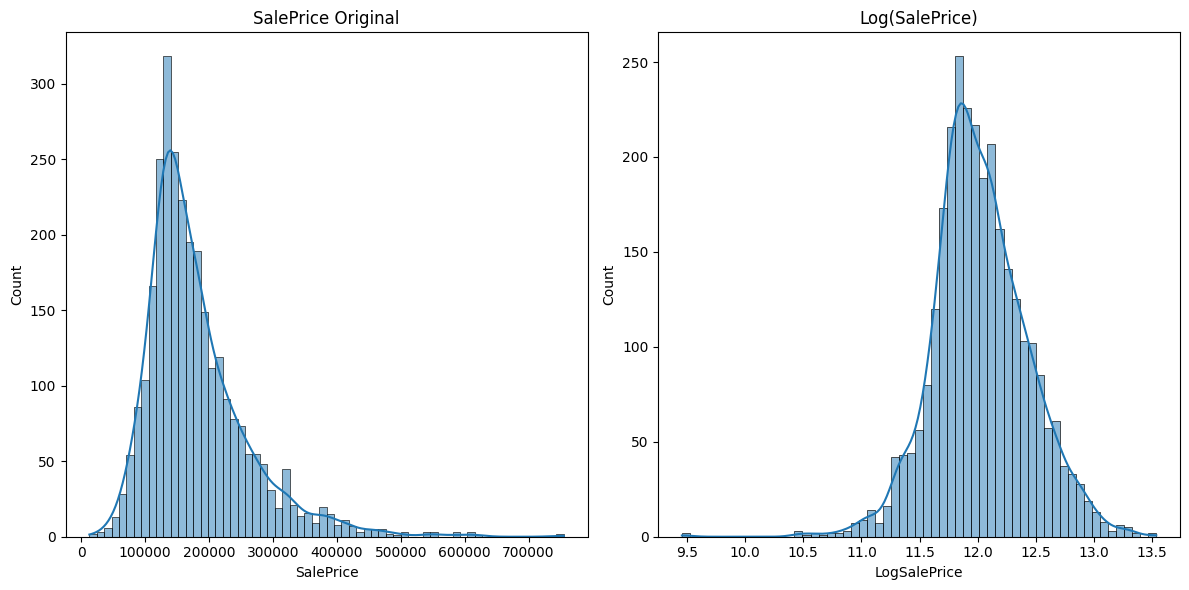

In [8]:
# Célula 7: Remoção de Outliers e Feature Engineering
# Removendo outliers extremos
outliers_liv_area = df_new[(df_new['Gr.Liv.Area'] > 4000) & (df_new['SalePrice'] < 300000)]
df_clean = df_new.drop(outliers_liv_area.index)

# Verificando número de registros após remoção
print(f"Registros originais: {len(df_new)}")
print(f"Registros após remoção de outliers: {len(df_clean)}")

# Feature Engineering
# 1. Criar novas features
df_clean['Age'] = df_clean['Year.Remod.Add'] - df_clean['Year.Built']
df_clean['TotalSF'] = df_clean['Gr.Liv.Area'] + df_clean['Total.Bsmt.SF']
df_clean['Bath.Rooms'] = df_clean['Full.Bath']
df_clean['HasFireplace'] = (df_clean['Fireplaces'] > 0).astype(int)
df_clean['HasGarage'] = (df_clean['Garage.Area'] > 0).astype(int)
df_clean['RecentRemodel'] = (df_clean['Year.Remod.Add'] > df_clean['Year.Built']).astype(int)

# 2. Transformação logarítmica para normalizar a variável alvo
df_clean['LogSalePrice'] = np.log(df_clean['SalePrice'])

# Verificando a distribuição da variável alvo transformada
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_clean['SalePrice'], kde=True)
plt.title('SalePrice Original')
plt.subplot(1, 2, 2)
sns.histplot(df_clean['LogSalePrice'], kde=True)
plt.title('Log(SalePrice)')
plt.tight_layout()
plt.show()

In [9]:
# Célula 8: Preparação para Modelagem
# Dividindo em features e target
X = df_clean.drop(['SalePrice', 'LogSalePrice'], axis=1)
y = df_clean['LogSalePrice']

# Identificando tipos de colunas
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# Divisão em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessamento
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

In [10]:
# Célula 9: Definição dos Modelos (corrigida)
# 1. Modelo trivial: média do preço (baseline)
class MeanRegressor:
    def __init__(self):
        self.mean = None
        
    def fit(self, X, y):
        self.mean = y.mean()
        return self
    
    def predict(self, X):
        return np.ones(X.shape[0]) * self.mean
    
    # Método necessário para compatibilidade com scikit-learn
    def get_params(self, deep=True):
        return {}
    
    # Método necessário para compatibilidade com scikit-learn
    def set_params(self, **params):
        return self

# 2. Modelo simples: Regressão Linear
lin_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# 3. Modelo Ridge com regularização
ridge_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

# 4. Modelo Lasso com regularização
lasso_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso())
])

# 5. Random Forest
rf_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [11]:
# Célula 10: Avaliação Inicial dos Modelos
# Função para avaliar os modelos com validação cruzada
def evaluate_model(model, X, y, cv=5):
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-cv_scores)
    return {
        'mean_rmse': rmse_scores.mean(),
        'std_rmse': rmse_scores.std()
    }

# Avaliação inicial de todos os modelos
models = {
    'Trivial (média)': MeanRegressor(),
    'Linear Regression': lin_reg,
    'Ridge Regression': ridge_reg,
    'Lasso Regression': lasso_reg,
    'Random Forest': rf_reg,
}

results = {}
for name, model in models.items():
    print(f"Avaliando {name}...")
    results[name] = evaluate_model(model, X_train, y_train)
    print(f"  RMSE: {results[name]['mean_rmse']:.4f} ± {results[name]['std_rmse']:.4f}")

Avaliando Trivial (média)...
  RMSE: 0.4032 ± 0.0186
Avaliando Linear Regression...
  RMSE: 0.1504 ± 0.0197
Avaliando Ridge Regression...
  RMSE: 0.1506 ± 0.0199
Avaliando Lasso Regression...
  RMSE: 0.4032 ± 0.0186
Avaliando Random Forest...
  RMSE: 0.1591 ± 0.0188


In [12]:
# Célula 11: Ajuste de Hiperparâmetros - Ridge
# Ridge
ridge_params = {
    'regressor__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
}
ridge_grid = GridSearchCV(ridge_reg, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)
print(f"Melhores parâmetros Ridge: {ridge_grid.best_params_}")
print(f"RMSE Ridge otimizado: {np.sqrt(-ridge_grid.best_score_):.4f}")

Melhores parâmetros Ridge: {'regressor__alpha': 0.01}
RMSE Ridge otimizado: 0.1517


In [13]:
# Célula 12: Ajuste de Hiperparâmetros - Random Forest
# Random Forest
rf_params = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10]
}
rf_grid = GridSearchCV(rf_reg, rf_params, cv=5, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)
print(f"Melhores parâmetros Random Forest: {rf_grid.best_params_}")
print(f"RMSE Random Forest otimizado: {np.sqrt(-rf_grid.best_score_):.4f}")

Melhores parâmetros Random Forest: {'regressor__max_depth': None, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200}
RMSE Random Forest otimizado: 0.1595


In [14]:
# Célula 13: Comparação Final dos Modelos
# Comparação final de modelos otimizados
best_models = {
    'Trivial (média)': MeanRegressor(),
    'Linear Regression': lin_reg,
    'Ridge (otimizado)': ridge_grid.best_estimator_,
    'Random Forest (otimizado)': rf_grid.best_estimator_
}

final_results = {}
for name, model in best_models.items():
    if name != 'Trivial (média)' and name != 'Linear Regression':
        # Estes modelos já estão treinados
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
    else:
        # Treinar estes modelos
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
    
    final_results[name] = {
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    }

# Convertendo para DataFrame para visualização
final_df = pd.DataFrame(final_results).T
print("\nResultados Finais no Conjunto de Teste:")
print(final_df)


Resultados Finais no Conjunto de Teste:
                               RMSE       MAE        R²
Trivial (média)            0.423822  0.324938 -0.000010
Linear Regression          0.125824  0.093293  0.911862
Ridge (otimizado)          0.125822  0.093291  0.911865
Random Forest (otimizado)  0.131805  0.094235  0.903283


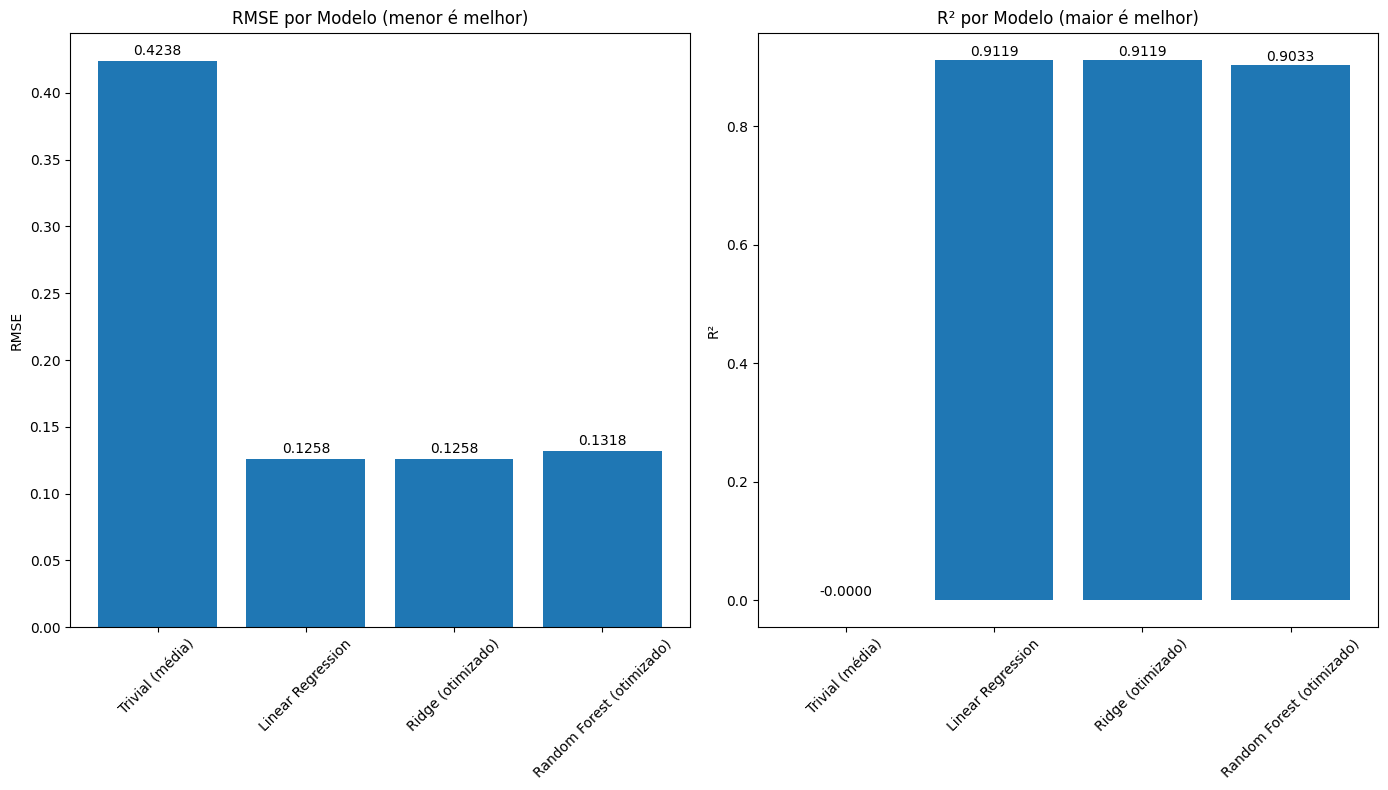


O melhor modelo é: Ridge (otimizado)


In [15]:
# Célula 14: Visualização dos Resultados
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
bars = plt.bar(final_df.index, final_df['RMSE'])
plt.title('RMSE por Modelo (menor é melhor)')
plt.xticks(rotation=45)
plt.ylabel('RMSE')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.002,
             f'{bar.get_height():.4f}', ha='center', va='bottom')

plt.subplot(1, 2, 2)
bars = plt.bar(final_df.index, final_df['R²'])
plt.title('R² por Modelo (maior é melhor)')
plt.xticks(rotation=45)
plt.ylabel('R²')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.002,
             f'{bar.get_height():.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Identificação do melhor modelo
best_model_name = final_df['R²'].idxmax()
print(f"\nO melhor modelo é: {best_model_name}")

In [16]:
# Célula 15: Avaliação Final do Melhor Modelo
# Pegando o melhor modelo
best_model = best_models[best_model_name]

# Avaliação final do melhor modelo convertendo de volta para preço original
# Transformar previsões de log para preço real
y_pred_log = best_model.predict(X_test)
y_pred_price = np.exp(y_pred_log)
y_test_price = np.exp(y_test)

# Calcular métricas de desempenho
rmse_price = np.sqrt(mean_squared_error(y_test_price, y_pred_price))
mae_price = mean_absolute_error(y_test_price, y_pred_price)
r2_price = r2_score(y_test_price, y_pred_price)

print(f"\nDesempenho final do {best_model_name} (valores em dólares):")
print(f"RMSE: ${rmse_price:.2f}")
print(f"MAE: ${mae_price:.2f}")
print(f"R²: {r2_price:.4f}")


Desempenho final do Ridge (otimizado) (valores em dólares):
RMSE: $24638.70
MAE: $16679.00
R²: 0.9247


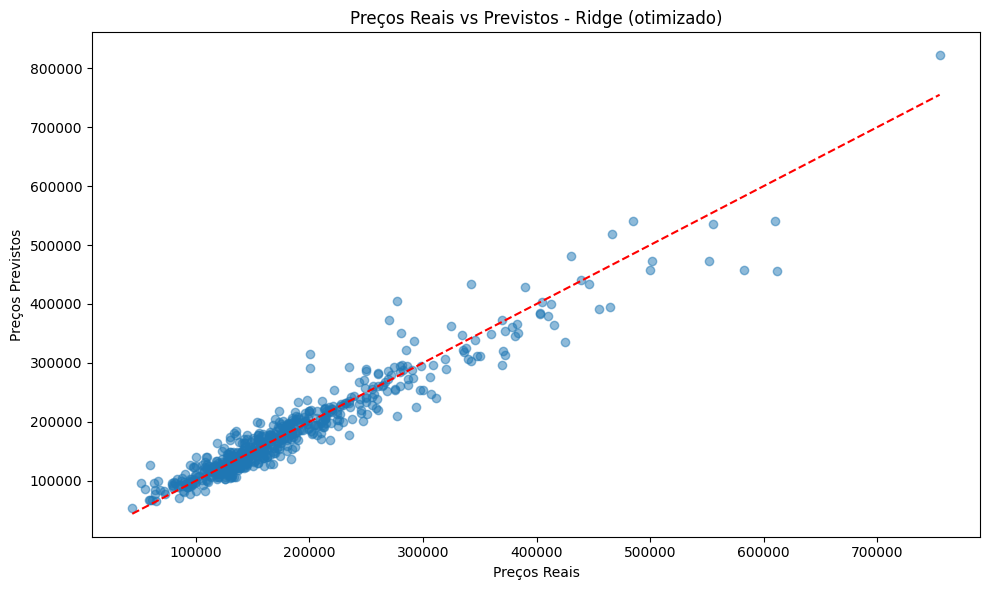

In [17]:
# Célula 16: Visualização das Previsões vs. Valores Reais
plt.figure(figsize=(10, 6))
plt.scatter(y_test_price, y_pred_price, alpha=0.5)
plt.plot([y_test_price.min(), y_test_price.max()], [y_test_price.min(), y_test_price.max()], 'r--')
plt.xlabel('Preços Reais')
plt.ylabel('Preços Previstos')
plt.title(f'Preços Reais vs Previstos - {best_model_name}')
plt.tight_layout()
plt.show()

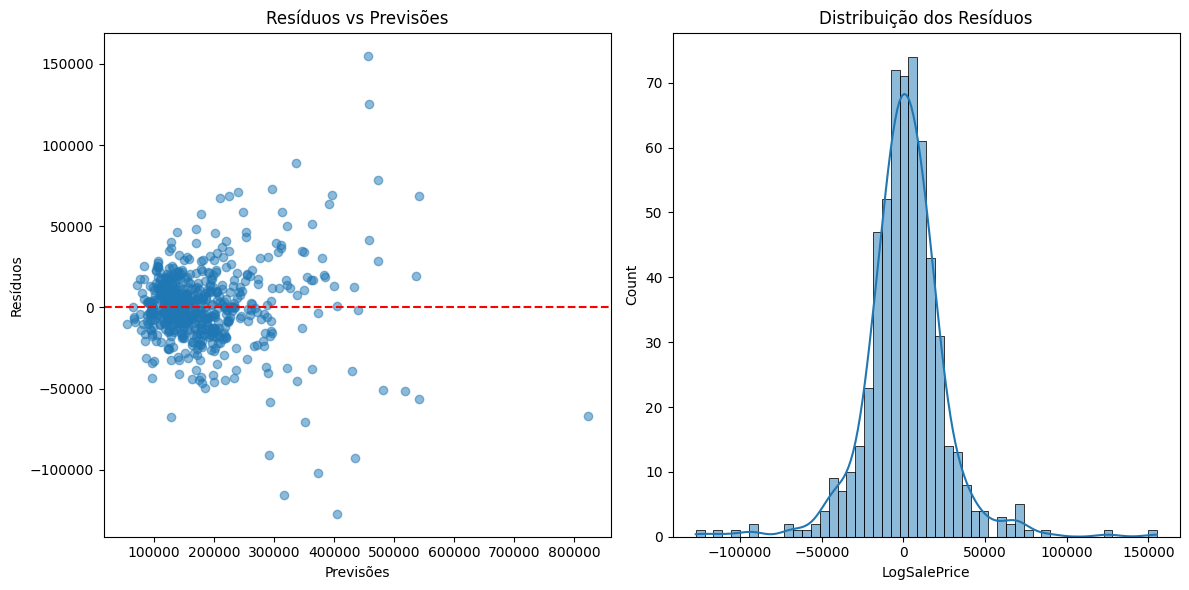

In [18]:
# Célula 17: Análise de Resíduos
residuals = y_test_price - y_pred_price
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_pred_price, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.title('Resíduos vs Previsões')

plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.title('Distribuição dos Resíduos')
plt.tight_layout()
plt.show()

In [19]:
# Célula 18: Análise de Importância de Features (apenas para modelos baseados em árvores)
if 'Random Forest' in best_model_name:
    # Extração das features após processamento
    preprocessed_X_train = best_model.named_steps['preprocessor'].transform(X_train)
    
    # Extração do modelo após processamento
    model = best_model.named_steps['regressor']
    
    # Obtenção da importância das features
    feature_importances = model.feature_importances_
    
    # Criação de um DataFrame para visualização
    feature_names = []
    
    # Para features numéricas
    if num_cols:
        feature_names.extend(num_cols)
    
    # Para features categóricas
    if cat_cols:
        # Obtenha os nomes das features categóricas após one-hot encoding
        ohe = best_model.named_steps['preprocessor'].transformers_[1][1]['onehot']
        cat_feature_names = ohe.get_feature_names_out(cat_cols)
        feature_names.extend(cat_feature_names)
    
    # Ajustar comprimento se necessário (caso de transformações adicionais)
    if len(feature_names) != len(feature_importances):
        feature_names = [f'Feature {i}' for i in range(len(feature_importances))]
    
    # Criar DataFrame de importâncias
    importances_df = pd.DataFrame({
        'Feature': feature_names[:len(feature_importances)],
        'Importance': feature_importances
    }).sort_values('Importance', ascending=False)
    
    # Visualizar top 20 features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importances_df.head(20))
    plt.title(f'Top 20 Features Importantes - {best_model_name}')
    plt.tight_layout()
    plt.show()

In [20]:
# Célula 19: Conclusões
print("Conclusões da Análise:")
print(f"1. O melhor modelo foi {best_model_name}")
print(f"2. Desempenho no conjunto de teste (R²): {r2_price:.4f}")
print("3. As variáveis mais importantes para prever o preço das casas são:")
if 'Random Forest' in best_model_name or 'Gradient Boosting' in best_model_name:
    for i, row in importances_df.head(5).iterrows():
        print(f"   - {row['Feature']}: {row['Importance']:.4f}")
print("4. O modelo consegue prever os preços com erro médio absoluto de ${:.2f}".format(mae_price))

Conclusões da Análise:
1. O melhor modelo foi Ridge (otimizado)
2. Desempenho no conjunto de teste (R²): 0.9247
3. As variáveis mais importantes para prever o preço das casas são:
4. O modelo consegue prever os preços com erro médio absoluto de $16679.00
